In [ ]:
# Nhập các thư viện
import pandas as pd
import spacy
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import warnings
warnings.filterwarnings("ignore")
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
from imblearn.over_sampling import RandomOverSampler
import string
string.punctuation
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Đọc dữ liệu
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Restaurant reviews.csv")

In [ ]:
# Kiểm tra số dòng và cột trong dữ liệu
df.shape

(10000, 8)

In [ ]:
# Kiểm tra dữ liệu
df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [ ]:
df['Review']

0       The ambience was good, food was quite good . h...
1       Ambience is too good for a pleasant evening. S...
2       A must try.. great food great ambience. Thnx f...
3       Soumen das and Arun was a great guy. Only beca...
4       Food is good.we ordered Kodi drumsticks and ba...
                              ...                        
9995    Madhumathi Mahajan Well to start with nice cou...
9996    This place has never disappointed us.. The foo...
9997    Bad rating is mainly because of "Chicken Bone ...
9998    I personally love and prefer Chinese Food. Had...
9999    Checked in here to try some delicious chinese ...
Name: Review, Length: 10000, dtype: object

In [ ]:
# Loại bỏ các cột không cần thiết
df = df.drop(['Time', 'Pictures', '7514'], axis=1)

In [ ]:
df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower"
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers"


In [ ]:
# Lấy thông tin cơ bản về dữ liệu
df.describe()


,Restaurant,Reviewer,Review,Rating,Metadata
count,10000,9962,9955,9962,9962
unique,100,7446,9364,10,2477
top,Beyond Flavours,Parijat Ray,good,5,1 Review
freq,100,13,237,3832,919


In [ ]:
# Loại bỏ những thông tin không liên quan trong dữ liệu: Giá trị Rating là 'Like' thay vì là một số. Loại bỏ hàng có giá trị Rating là "Like"
print(df['Rating'].value_counts())
df = df[df['Rating'] != 'Like']
print("="*50)
print(df['Rating'].value_counts())

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64
5      3832
4      2373
1      1735
3      1193
2       684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64


In [ ]:
df.tail()

,Restaurant,Reviewer,Review,Rating,Metadata
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers"
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers"
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers"
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers"
9999,Chinese Pavilion,Bhargava Krishna,Checked in here to try some delicious chinese ...,3.5,"472 Reviews , 1302 Followers"


In [ ]:
# 1. Các nhà hàng được đánh giá cao nhất là những nhà hàng có hơn k (giả sử 70) đánh giá 5 sao trên tổng số 100 đánh giá.

def top_rated_restaurants(df, k):
    """Trả về các nhà hàng được đánh giá cao nhất trong dữ liệu"""
    # Nhóm các nhà hàng với tất cả các đánh giá cho mỗi nhà hàng
    df = df.groupby('Restaurant')['Rating'].apply(list).reset_index()
    # Trả về các nhà hàng có hơn k đánh giá 5 sao
    df = df[df['Rating'].apply(lambda x: x.count('5')) > k]
    return df['Restaurant'].to_list()

print(top_rated_restaurants(df, 70))


["3B's - Buddies, Bar & Barbecue", "AB's - Absolute Barbecues", 'B-Dubs', 'Flechazo', 'Paradise', 'The Indi Grill']


In [ ]:
# 2. Tổng quan về cảm xúc của các đánh giá cho mỗi nhà hàng: Cho một nhà hàng, chúng ta tính trung bình và trung vị của các đánh giá cho mỗi nhà hàng.

def overall_sentiment(df, restaurant_name):
    """Trả về tổng quan về cảm xúc cho một nhà hàng cụ thể"""
    # Chuyển đổi các giá trị cột 'Rating' thành dạng số
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    # Tính toán giá trị trung bình và trung vị của các đánh giá cho mỗi nhà hàng
    df = df.groupby('Restaurant')['Rating'].agg(['mean', 'median']).reset_index()
    # Trả về giá trị trung bình và trung vị của Ratings cho một nhà hàng cụ thể
    result_dict = {
        "Average": df[df['Restaurant'] == restaurant_name]['mean'].values[0],
        "Median": df[df['Restaurant'] == restaurant_name]['median'].values[0]
    }
    return json.dumps(result_dict)

overall_sentiment(df, "13 Dhaba")

'{"Average": 3.48, "Median": 4.0}'

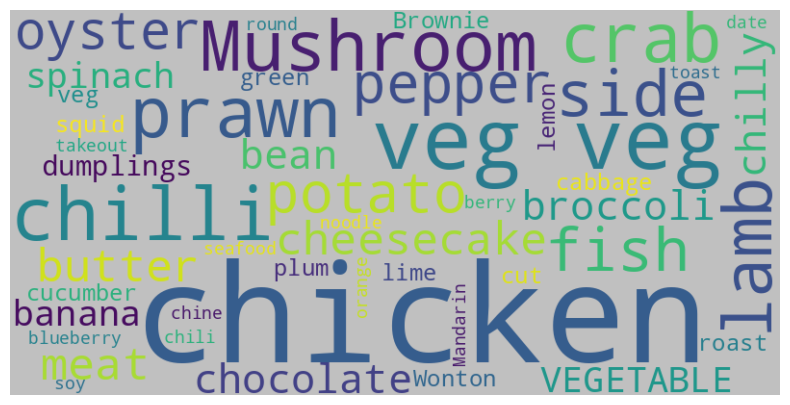

In [ ]:
# 3. Các món ăn phổ biến trong một nhà hàng cụ thể

def get_all_food_items():
    """Lấy tất cả các từ khóa món ăn"""
    food = wn.synset('food.n.02')
    food_items_all = list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
    return food_items_all

def get_popular_foods(text, food_item_keywords):
    """Lấy tất cả các món ăn từ văn bản đầu vào"""
    # Tải mô hình spaCy cho tiếng Anh
    nlp = spacy.load("en_core_web_sm")
    # Xử lý văn bản đầu vào bằng spaCy
    doc = nlp(text)
    # Trích xuất các món ăn dựa trên các từ khóa
    food_keywords = food_item_keywords
    food_items = [token.text for token in doc if token.text.lower() in food_keywords]
    return " ".join(food_items)

def build_wordcloud(text):
    """Xây dựng wordcloud cho một văn bản được cung cấp"""
    wordcloud = WordCloud(width=800, height=400, background_color='silver')
    wordcloud.generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def popular_food_items(df, restaurant):
    """Hàm chính để lấy các món ăn phổ biến trong một nhà hàng cụ thể"""
    reviews = df[df['Restaurant'] == restaurant]['Review'].to_list()
    reviews_text = "".join(reviews)
    food_items_all = get_all_food_items()
    food_items = get_popular_foods(reviews_text, food_items_all)
    build_wordcloud(food_items)

popular_food_items(df, 'Chinese Pavilion')


In [ ]:
# 4. Tỷ lệ đánh giá negative cho mỗi nhà hàng

def neg_reviews_percentage(df, restaurant):
    """Tỷ lệ đánh giá negative cho một nhà hàng cụ thể"""
    # Đếm số lượng đánh giá tiêu cực cho một nhà hàng cụ thể
    neg_reviews = df[(df['Restaurant'] == restaurant) & (df['Rating'].astype('float') < 3)].shape[0]
    # In ra phần trăm đánh giá negative
    print(f"Nhà hàng \'{restaurant}\' có {str(neg_reviews)}% tổng số đánh giá negative")

neg_reviews_percentage(df, 'Beyond Flavours')
neg_reviews_percentage(df, 'Chinese Pavilion')


Nhà hàng 'Beyond Flavours' có 12% tổng số đánh giá negative
Nhà hàng 'Chinese Pavilion' có 13% tổng số đánh giá negative


## Sentiment analysis of reviews: Đưa ra một đánh giá, dự đoán tính phân cực (positive or negativec) của đánh giá.



In [ ]:
df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers"
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers"
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers"
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower"
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers"


## Data pre-processing.

In [ ]:
# Các bài đánh giá
df['Review'][0]

'The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.'

In [ ]:
# Công cụ tiền xử lý

def remove_stop_words(text):
    """Loại bỏ các stop words"""
    stopwords = nltk.corpus.stopwords.words('english')
    output = [word for word in text.split() if word not in stopwords]
    return " ".join(output)

def lemmatize_text(text):
    """Lemmatization văn bản"""
    word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_words = []
    for word in word_tokenizer.tokenize(text):
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return " ".join(lemmatized_words)

def pre_process_data(text):
    """Tiền xử lý dữ liệu văn bản"""
    # Loại bỏ dấu câu
    processed_text = "".join([i for i in str(text) if i not in string.punctuation])
    # Chuyển đổi về chữ thường
    processed_text = processed_text.lower()
    # Loại bỏ các từ dừng
    processed_text = remove_stop_words(processed_text)
    # Lemmatization văn bản
    processed_text = lemmatize_text(str(processed_text))
    return processed_text


In [ ]:
# Text mẫu để kiểm tra tiền xử lý

# pre_process_data("The cats are jumping over the fences.") # Output: cat jumping fence
# pre_process_data("goes") # Output: go
pre_process_data("goods")

'good'

In [ ]:
# Tiền xử lý các đánh giá trong dữ liệu nhà hàng
df['Review_pre_processed'] = df['Review'].apply(lambda text : pre_process_data(text))

In [ ]:
# Kiểm tra dữ liệu sau khi đã tiền xử lý
df.head(4)


,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...


In [ ]:
# Đánh dấu polarity của các đánh giá trong dữ liệu
def polarize_rating(rating):
    """Đánh dấu polarity của dữ liệu"""
    # Một đánh giá là negative nếu điểm đánh giá nhỏ hơn 3, ngược lại là positive
    if rating < 3:
        return 'negative'
    else:
        return 'positive'

# Áp dụng hàm vào cột 'Rating' và tạo một cột mới 'ReviewPolarity'
df['ReviewPolarity'] = df['Rating'].apply(polarize_rating)


In [ ]:
# Kiểm tra các polarity được thêm vào
df.head(10)

,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed,ReviewPolarity
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",food goodwe ordered kodi drumstick basket mutt...,positive
5,Beyond Flavours,Nagabhavani K,"Ambiance is good, service is good, food is aPr...",5.0,1 Review,ambiance good service good food apradeecp subr...,positive
6,Beyond Flavours,Jamuna Bhuwalka,"Its a very nice place, ambience is different, ...",5.0,1 Review,nice place ambience different food ordered tas...,positive
7,Beyond Flavours,Sandhya S,Well after reading so many reviews finally vis...,4.0,1 Review,well reading many review finally visited place...,positive
8,Beyond Flavours,Akash Thorat,"Excellent food , specially if you like spicy f...",5.0,"1 Review , 1 Follower",excellent food specially like spicy food court...,positive
9,Beyond Flavours,Smarak Patnaik,Came for the birthday treat of a close friend....,5.0,"1 Review , 1 Follower",came birthday treat close friend perfect place...,positive


In [ ]:
# Kiểm tra dữ liệu có cân bằng hay không
df['ReviewPolarity'].value_counts()

positive    7552
negative    2447
Name: ReviewPolarity, dtype: int64

## Vì dữ liệu mất cân bằng nên sẽ lấy mẫu bằng cách oversampling.

Nhân số lượng dữ liệu bị chênh lệch lên nhiều lần để có một data cân xứng hơn.

In [ ]:
# Tách các đặc trưng và nhãn
y = df['ReviewPolarity']
X = df.drop(['ReviewPolarity'], axis=1)

In [ ]:
y = df['ReviewPolarity']
X = df.drop(['ReviewPolarity'], axis=1)
# Oversampling
def over_sampler(X, y):
    """Thực hiện oversampling trên dữ liệu"""
    oversampler = RandomOverSampler(sampling_strategy=1.0)
    return oversampler.fit_resample(X, y)

X_balanced, y_balanced = over_sampler(X, y)
print(X_balanced.shape, y_balanced.shape)
balanced_df = pd.concat([X_balanced, y_balanced], axis=1)
balanced_df

(15104, 6) (15104,)


,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed,ReviewPolarity
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",food goodwe ordered kodi drumstick basket mutt...,positive
...,...,...,...,...,...,...,...
15099,Karachi Bakery,Bypina Nagendra Chowdary,Very dry items ..pastry is not juicy . sandwic...,1.0,"6 Reviews , 4 Followers",dry item pastry juicy sandwich worst taste muf...,negative
15100,Club Rogue,Sai Kiran,"Me and boys went to watch match here, we are r...",1.0,"13 Reviews , 62 Followers",boy went watch match regular customer manager ...,negative
15101,Green Bawarchi Restaurant,Abhinav Sinha,DONT EVER ORDER FROM THIS PLACE. THEY SERVE TA...,1.0,"1 Review , 20 Followers",dont ever order place serve tasteless raw chic...,negative
15102,Banana Leaf Multicuisine Restaurant,Santosh Reddy.R,not good. chicken pieces are fully roasted. Di...,1.0,"2 Reviews , 2 Followers",good chicken piece fully roasted disappointed ...,negative


In [ ]:
# Dữ liệu đã được cân bằng
balanced_df = pd.concat([X_balanced, y_balanced], axis=1)
balanced_df.head(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Review_pre_processed,ReviewPolarity
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",ambience good food quite good saturday lunch c...,positive
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",ambience good pleasant evening service prompt ...,positive
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",must try great food great ambience thnx servic...,positive
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",soumen da arun great guy behavior sincerety go...,positive
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",food goodwe ordered kodi drumstick basket mutt...,positive


In [ ]:
# Dữ liệu
data = balanced_df['Review']
data = [str(item) for item in data]
# print(data)
# Khởi tạo và tiền xử lý dữ liệu với Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)

# Xác định vocab_size
vocab_size = len(tokenizer.word_index) + 1  # Thêm 1 cho từ không xác định (unknown word)

print("Vocab size:", vocab_size)

Vocab size: 16248


In [ ]:
# Kiểm tra lại dữ liệu
balanced_df['ReviewPolarity'].value_counts()

positive    7552
negative    7552
Name: ReviewPolarity, dtype: int64

In [ ]:
# Tạo train-test split
def train_test_data_split(X, y):
    """Chia dữ liệu thành tập huấn luyện và tập kiểm tra"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_data_split(X_balanced, y_balanced)


In [ ]:
# Trích xuất các đánh giá và nhãn lớp từ tập train-test
X_train_reviews = X_train['Review'].values.astype('str')
X_test_reviews = X_test['Review'].values.astype('str')
y_train_labels = y_train.values
y_test_labels = y_test.values

# Mã hóa các nhãn lớp
encoder = LabelEncoder()
y_train_encoded_labels = encoder.fit_transform(y_train_labels)
y_test_encoded_labels = encoder.transform(y_test_labels)


In [ ]:
# Khởi tạo mô hình
# Siêu tham số của mô hình
vocab_size = 16248
oov_tok = ''
embedding_dim = 256
max_length = 256
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_reviews)
word_index = tokenizer.word_index
# chuyển đổi tập dữ liệu huấn luyện thành chuỗi và đệm chuỗi
train_sequences = tokenizer.texts_to_sequences(X_train_reviews)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# chuyển đổi tập dữ liệu kiểm tra thành chuỗi và đệm chuỗi
test_sequences = tokenizer.texts_to_sequences(X_test_reviews)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 256)          4159488   
                                                                 
 bidirectional (Bidirection  (None, 128)               164352    
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 4326961 (16.51 MB)
Trainable params: 4326961 (16.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Đào tạo và đánh giá mô hình
history = model.fit(train_padded, y_train_encoded_labels, epochs=5, verbose=1, validation_split=0.1)
model.save("/content/drive/MyDrive/Colab Notebooks/my_model.h5")
prediction = model.predict(test_padded)
# Lấy nhãn dựa trên xác suất 1 nếu p >= 0.5, ngược lại là 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

print("Độ chính xác của dự đoán trên tập dữ liệu test: ", accuracy_score(y_test_encoded_labels, pred_labels))


Epoch 1/5
340/340 [==============================] - 221s 633ms/step - loss: 0.2882 - accuracy: 0.8768 - val_loss: 0.2142 - val_accuracy: 0.9313
Epoch 2/5
340/340 [==============================] - 215s 632ms/step - loss: 0.1259 - accuracy: 0.9595 - val_loss: 0.1742 - val_accuracy: 0.9462
Epoch 3/5
340/340 [==============================] - 220s 647ms/step - loss: 0.0984 - accuracy: 0.9686 - val_loss: 0.1723 - val_accuracy: 0.9462
Epoch 4/5
340/340 [==============================] - 219s 644ms/step - loss: 0.0763 - accuracy: 0.9754 - val_loss: 0.2003 - val_accuracy: 0.9330
Epoch 5/5
95/95 [==============================] - 27s 273ms/step
Độ chính xác của dự đoán trên tập dữ liệu test:  0.9470374048328368


In [ ]:
# Tải mô hình đã lưu
loaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/my_model.h5")
prediction = loaded_model.predict(test_padded)


95/95 [==============================] - 18s 177ms/step


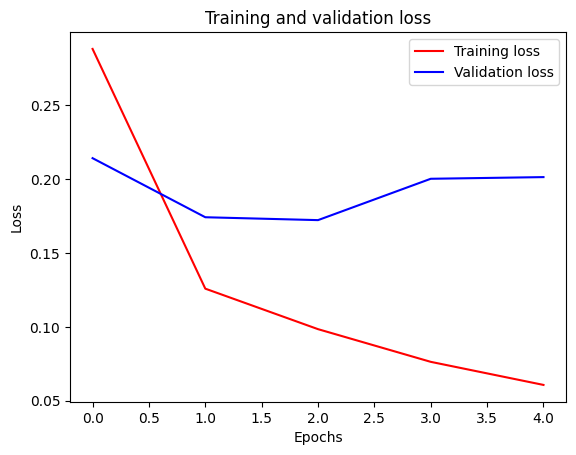

In [ ]:
# Lấy thông tin loss và accuracy từ history
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

# Vẽ biểu đồ loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


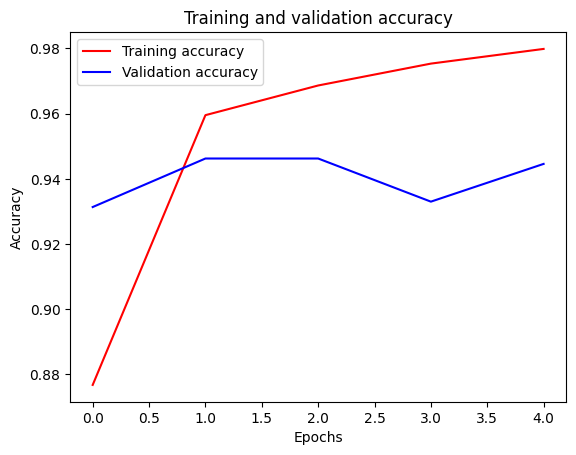

In [ ]:
# Vẽ biểu đồ accuracy
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Chuỗi đầu vào
sentences = [
    "I had a bad experience at this restaurant. The service was slow, and the food was not good. I wouldn't recommend eating here.",
    "The restaurant gave an okay dining experience. The atmosphere was nice, and the service was fast. The food was average, but it was alright overall.",
    "I had a disappointing experience dining here. The food was bland, the service was slow, and the atmosphere wasn't pleasant. I wouldn't suggest this place to anyone.",
    "Great experience. Exceeded my expectations."
]
# Chuyển đổi câu thành chuỗi số nguyên và đệm chuỗi
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Dự đoán cảm xúc
predictions = model.predict(padded)
# Dịch các dự đoán thành nhãn cảm xúc
labels = ['Negative' if pred < 0.5 else 'Positive' for pred in predictions]
# In kết quả
for sentence, label in zip(sentences, labels):
    print(f"Sentence: {sentence}")
    print(f"Predicted sentiment: {label}")
    print("=" * 50)


1/1 [==============================] - 0s 55ms/step
Sentence: I had a bad experience at this restaurant. The service was slow, and the food was not good. I wouldn't recommend eating here.
Predicted sentiment: Negative
Sentence: The restaurant gave an okay dining experience. The atmosphere was nice, and the service was fast. The food was average, but it was alright overall.
Predicted sentiment: Positive
Sentence: I had a disappointing experience dining here. The food was bland, the service was slow, and the atmosphere wasn't pleasant. I wouldn't suggest this place to anyone.
Predicted sentiment: Negative
Sentence: Great experience. Exceeded my expectations.
Predicted sentiment: Positive


In [ ]:
# Ref:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
# https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/